# Summary of fragmentomics features in FinaleTools
This figure presents a precise summary of all of the fragmentomics features that can be calculated using the FinaleTools package and command line program.

### Features to Represent
- Fragment Coverage
- Fragment Lengths
- Window Protection Score (WPS)
- DNA evaluation of fragments for early interception (DELFI)
- End motifs
- Motif Diversity Score (MDS)

In [118]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyBigWig as pbw
import numpy as np
import pandas as pd
import scipy.stats as stats
import gzip
from statsmodels.regression.linear_model import OLS
from finaletools.frag.frag_length import frag_length_bins
from finaletools.frag.coverage import coverage
from finaletools.frag.end_motifs import end_motifs

## Window Protection Score

In [68]:
# Window Protection Score
"""
ft_wps = []
with open("../data/BH01.chr12_asat.LWPS.raw.bedGraph", 'r') as ft_wps_file:
    for line in ft_wps_file:
        contents = line.split()
        ft_wps.append((contents[0], int(contents[1]), int(contents[2]), float(contents[3])))
"""
with pbw.open('../data/chr12_asat_07-28-23.bw', 'r') as bigwig:
    scores = bigwig.values('12', 34442000, 34447000)
    ft_wps = [('12', pos, pos+1, score) for pos, score in zip(range(34442000, 34447001), scores)]


shendure_wps = []
with gzip.open('../data/shendure.BH01.chr12.asat.wps.wig.gz', 'rt') as shendure_file:
    lines = shendure_file.readlines()
    header = lines[0].split()
    chrom = header[1].split('=')[1][3:]
    start = int(header[2].split('=')[1])
    step = int(header[3].split('=')[1])
    pos = start
    for line in lines[1:]:
        score = float(line)
        shendure_wps.append((chrom, pos, pos+1, score))
        pos += 1
ft_wps = np.array(ft_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
shendure_wps = np.array(shendure_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
ft_wps, shendure_wps

(array([('12', 34442000, 34442001, -52.), ('12', 34442001, 34442002, -52.),
        ('12', 34442002, 34442003, -51.), ...,
        ('12', 34446997, 34446998, -59.), ('12', 34446998, 34446999, -63.),
        ('12', 34446999, 34447000, -64.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]),
 array([('12', 34442000, 34442001, -52.), ('12', 34442001, 34442002, -49.),
        ('12', 34442002, 34442003, -51.), ...,
        ('12', 34446998, 34446999, -62.), ('12', 34446999, 34447000, -64.),
        ('12', 34447000, 34447001, -61.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]))

In [69]:
# Get stats
pearson, _ = stats.pearsonr(shendure_wps['score'][:-1], ft_wps['score'])
spearman, _ = stats.spearmanr(shendure_wps['score'][:-1], ft_wps['score'])

pearson, spearman

(0.9978896817003999, 0.9976844186960905)

In [70]:
# Regression line
ols = OLS(ft_wps['score'], shendure_wps['score'][:-1])
model = ols.fit()
regression = model.predict(shendure_wps['score'])
r2 = model.rsquared_adj
r2

0.9990071932668556

Text(0.5, 1.0, '(B)')

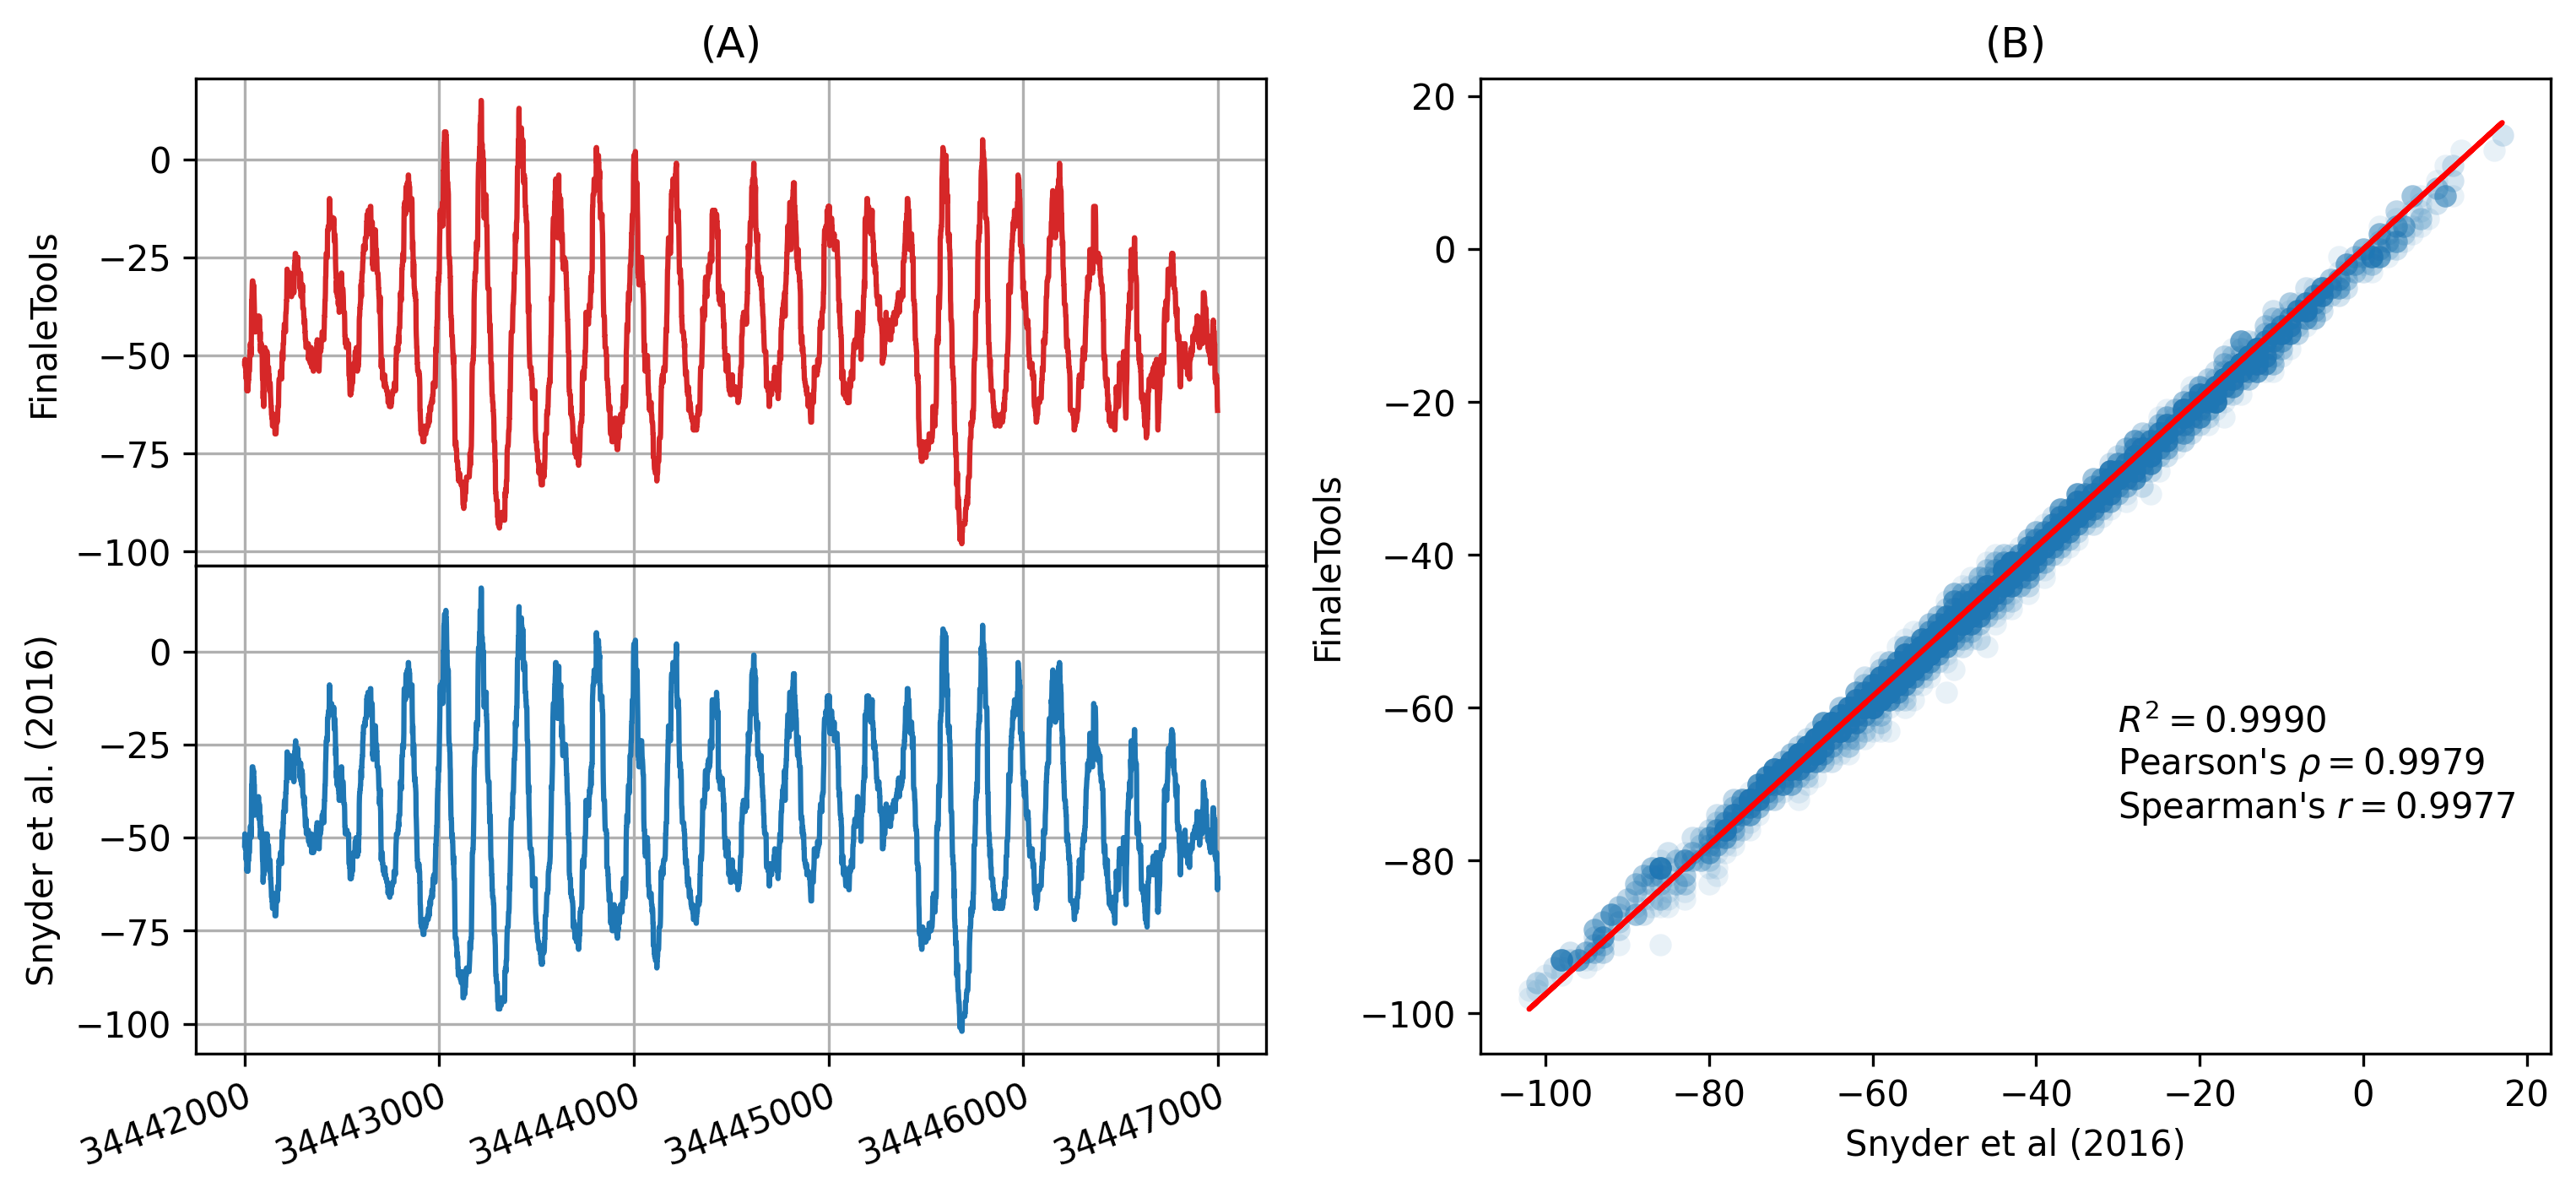

In [71]:
# plotting comparison
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_dpi(300)
fig.set_size_inches(12, 5)
axes[0, 0].plot(ft_wps['start'], ft_wps['score'], 'C3', label="FinaleTools")
axes[0, 0].set_ylabel('FinaleTools')
axes[1, 0].plot(shendure_wps['start'], shendure_wps['score'], 'C0', label="Snyder et al. (2016)")
axes[1, 0].set_ylabel('Snyder et al. (2016)')

plt.setp(axes[1, 0].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
x_formatter.set_scientific(False)

fig.subplots_adjust(hspace=0)

axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[0, 0].grid()
axes[1, 0].grid()

gs = axes[0, 1].get_gridspec()
for ax in axes[:, 1]:
    ax.remove()

# for fig B
scatter_ax = fig.add_subplot(gs[:, 1])
scatter_ax.scatter(shendure_wps['score'][:-1], ft_wps['score'], s=40, alpha=0.1, linewidths=0)
scatter_ax.plot(shendure_wps['score'], regression, 'r-')
scatter_ax.set_xlabel('Snyder et al (2016)')
scatter_ax.set_ylabel('FinaleTools')
stats_string = f"""$R^2={r2:.4f}$
Pearson's $\\rho = {pearson:.4f}$
Spearman's $r = {spearman:.4f}$
"""
scatter_ax.text(-30, -80, stats_string)
axes[0, 0].set_title('(A)')
scatter_ax.set_title('(B)')


### Performance testing

In [201]:
wps_performance = pd.read_csv('../data/wps_benchmark_7-28-23.csv', converters={'MaxRSS':lambda x:int(x[:-1])/1000000})
wps_performance

,Elapsed,NCPUS,CPUTime,TotalCPU,MaxRSS,Time
0,00:07:07,32,03:47:44,39:35.564,26.340816,403.854260
1,00:07:48,32,04:09:36,43:05.102,27.550896,449.661762
2,00:07:25,32,03:57:20,42:32.166,27.047904,425.929628
3,00:07:30,64,08:00:00,43:54.077,35.512488,425.211624
4,00:06:57,64,07:24:48,41:17.067,34.947468,395.156802
5,00:07:43,16,02:03:28,42:02.578,18.574236,440.674938
6,00:07:54,16,02:06:24,42:24.005,19.355064,446.934186
7,00:07:42,24,03:04:48,40:58.241,23.933052,436.791493
8,00:07:46,24,03:06:24,41:19.398,23.933920,439.202999
9,00:07:13,48,05:46:24,41:18.388,31.899912,409.419798


In [202]:
mean_times = []

n_cpus = np.unique(wps_performance['NCPUS'])
for n_cpu in n_cpus:
    mean_times.append(np.mean(wps_performance.loc[wps_performance['NCPUS']==n_cpu, 'Time']))

n_cpus_times = np.array(list(zip(n_cpus, mean_times)), dtype=[('NCPUS', 'i8'), ('Time', 'f8')])
n_cpus_times


array([( 2,          nan), (16, 443.80456209), (24, 437.99724627),
       (32, 426.48188321), (48, 415.48560357), (64, 410.18421292)],
      dtype=[('NCPUS', '<i8'), ('Time', '<f8')])

In [203]:
mean_mem = []

n_cpus = np.unique(wps_performance['NCPUS'])
for n_cpu in n_cpus:
    mean_mem.append(np.mean(wps_performance.loc[wps_performance['NCPUS']==n_cpu, 'MaxRSS']))

n_cpus_mem = np.array(list(zip(n_cpus, mean_mem)), dtype=[('NCPUS', 'i8'), ('MaxRSS', 'f8')])
n_cpus_mem

array([( 2,  4.008138), (16, 18.96465 ), (24, 23.933486), (32, 26.979872),
       (48, 31.762202), (64, 35.229978)],
      dtype=[('NCPUS', '<i8'), ('MaxRSS', '<f8')])

Text(0.5, 1.0, '(B)')

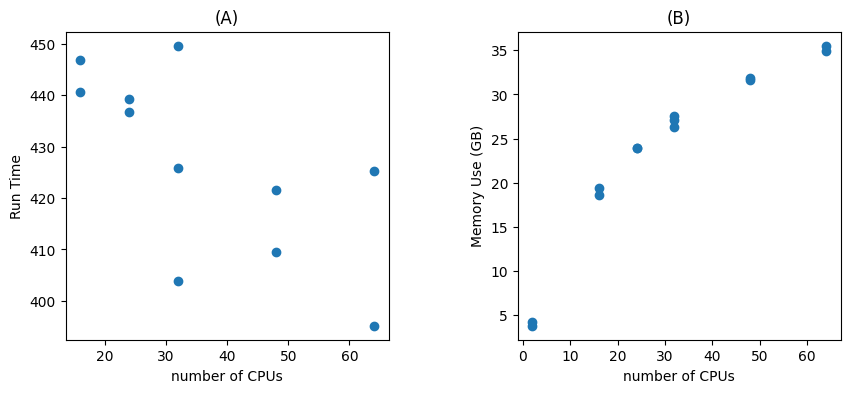

In [204]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.subplots_adjust(wspace=0.4)
axes[0].scatter(wps_performance['NCPUS'], wps_performance['Time'])
axes[0].set_xlabel('number of CPUs')
axes[0].set_ylabel('Run Time')
axes[0].set_title('(A)')
"""
axes[1].scatter(wps_performance['NCPUS'], wps_performance['TotalCPU'])
axes[1].set_xlabel('number of CPUs')
axes[1].set_xlabel('Total CPU Time')
"""
axes[1].scatter(wps_performance['NCPUS'], wps_performance['MaxRSS'])
axes[1].set_xlabel('number of CPUs')
axes[1].set_ylabel('Memory Use (GB)')
axes[1].set_title('(B)')

Text(0.5, 1.0, '(B)')

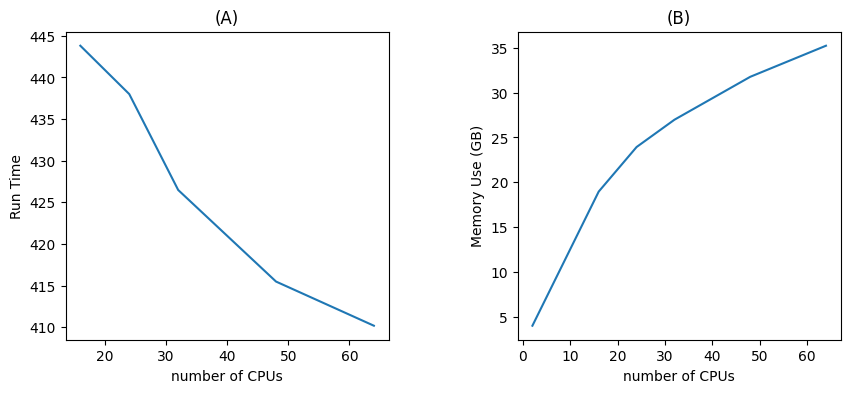

In [205]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.subplots_adjust(wspace=0.4)
axes[0].plot(n_cpus_times['NCPUS'], n_cpus_times['Time'])
axes[0].set_xlabel('number of CPUs')
axes[0].set_ylabel('Run Time')
axes[0].set_title('(A)')
# axes[0].plot([16, 64],[52567, 52567])
"""
axes[1].scatter(wps_performance['NCPUS'], wps_performance['TotalCPU'])
axes[1].set_xlabel('number of CPUs')
axes[1].set_xlabel('Total CPU Time')
"""
axes[1].plot(n_cpus_mem['NCPUS'], n_cpus_mem['MaxRSS'])
axes[1].set_xlabel('number of CPUs')
axes[1].set_ylabel('Memory Use (GB)')
axes[1].set_title('(B)')

[None, None, None, None, None, None, None, None, None, None, None, None]

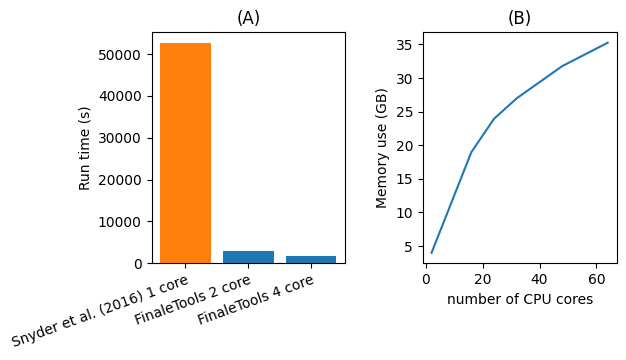

In [206]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(6, 3)
fig.subplots_adjust(wspace=0.4)
trials = [
    'Snyder et al. (2016) 1 core',
    'FinaleTools 2 core',
    'FinaleTools 4 core',
]
run_times = [
    52567,
    2934,
    1716,
]
colors = ['C1', 'C0', 'C0']
axes[0].bar(trials, run_times, color=colors)
# axes[0].set_xlabel('number of CPU cores')
axes[0].set_ylabel('Run time (s)')
axes[0].set_title('(A)')
# axes[0].plot([16, 64],[52567, 52567])
"""
axes[1].scatter(wps_performance['NCPUS'], wps_performance['TotalCPU'])
axes[1].set_xlabel('number of CPUs')
axes[1].set_xlabel('Total CPU Time')
"""
axes[1].plot(n_cpus_mem['NCPUS'], n_cpus_mem['MaxRSS'])
axes[1].set_xlabel('number of CPU cores')
axes[1].set_ylabel('Memory use (GB)')
axes[1].set_title('(B)')

plt.setp(axes[0].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")

In [ ]:
cores = [1, 2, 4]

## End-motifs
\[MDS=\sum_{i=1}^{256}{-P_i\cdot\log{(P_i)}}/\log{(256)}\]

In [44]:
# read data from csv. The csv is our end-motif calculations on a dataset
# from Jiang et al (2015), which is different from the data used in 
# Jiang et al (2020).
end_motifs_csv = pd.read_csv('../data/jiang_end_motifs_Jul26.csv')
end_motifs_csv

,id,disease,mds,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,85754,Hepatitis B,0.947495,0.011284,0.003569,0.005924,0.006254,0.003893,0.001974,0.000456,...,0.000257,0.002132,0.002941,0.001326,0.001573,0.002221,0.004500,0.003509,0.003042,0.007699
1,85755,Hepatitis B,0.948387,0.011045,0.003601,0.006175,0.006197,0.003859,0.001923,0.000460,...,0.000325,0.002010,0.002902,0.001334,0.001717,0.002235,0.004302,0.003250,0.002993,0.007289
2,85756,Healthy,0.947905,0.011265,0.003707,0.006101,0.006640,0.004126,0.002060,0.000435,...,0.000245,0.002115,0.002787,0.001230,0.001514,0.002151,0.004530,0.003367,0.002914,0.007747
3,85757,Healthy,0.950097,0.010833,0.003395,0.006096,0.006019,0.003683,0.001848,0.000421,...,0.000304,0.002358,0.003180,0.001470,0.002162,0.002446,0.004397,0.003397,0.003219,0.007716
4,85758,Cirrhosis,0.950011,0.011578,0.003604,0.006158,0.006427,0.003929,0.001954,0.000433,...,0.000296,0.002281,0.003018,0.001425,0.001888,0.002341,0.004431,0.003438,0.003138,0.007805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,85998,Cirrhosis,0.948255,0.011463,0.003826,0.006095,0.006774,0.004295,0.002113,0.000464,...,0.000230,0.001787,0.002424,0.001077,0.001222,0.001927,0.004208,0.003121,0.002668,0.007549
221,85999,Hepatitis B,0.947335,0.011075,0.003744,0.006048,0.006409,0.004031,0.002095,0.000453,...,0.000248,0.001885,0.002700,0.001220,0.001400,0.002064,0.004298,0.003506,0.002876,0.007598
222,86000,Liver cancer,0.948355,0.010940,0.003539,0.005850,0.006262,0.003850,0.001910,0.000422,...,0.000291,0.002079,0.002839,0.001363,0.001619,0.002245,0.004545,0.003525,0.003106,0.008053
223,86001,Hepatitis B,0.946293,0.011402,0.003728,0.006063,0.006537,0.004094,0.002115,0.000440,...,0.000250,0.001954,0.002688,0.001217,0.001373,0.002084,0.004401,0.003364,0.002884,0.007609


In [45]:
# get mds for Healthy, HBV, and HCC
# NOTE: this dataset was retrived from FinaleDB, which uses the 'Liver
# cancer' label for some samples. Jiang et al (2015) makes no mention of
# non-HCC liver cancers in their patients, so it is assumed that all
# samples labled 'Liver cancer' are also HCC.
healthy_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Healthy', 'mds']
hbv_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Hepatitis B', 'mds']
hcc_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', 'mds']
mds_series = [healthy_mds, hbv_mds, hcc_mds]
healthy_mds

2      0.947905
3      0.950097
16     0.948226
21     0.948790
28     0.949936
31     0.948068
35     0.948317
39     0.949179
57     0.949183
68     0.948407
80     0.949553
90     0.948033
96     0.949537
97     0.948612
114    0.947631
132    0.948767
138    0.948307
139    0.949535
142    0.947923
149    0.948289
159    0.951259
165    0.948702
166    0.949698
170    0.952225
186    0.948399
190    0.947978
197    0.948463
198    0.947959
204    0.948288
209    0.949744
211    0.949542
212    0.948031
Name: mds, dtype: float64

In [48]:
# Get motif freqs of non-HCC and HCC patients for six motifs of interest
# for HCC
motifs = ['CCCA', 'CCAG', 'CCTG', 'TAAA', 'AAAA', 'TTTT']

# motif-freqs are stored in DataFrames in a list. For each motif there
# is a DataFrame for Non-HCC and a DataFrame for HCC

motif_freq_list = []
for motif in motifs:
    non_hcc = end_motifs_csv.loc[(end_motifs_csv['disease']=='Healthy'), motif]
    hcc = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', motif]
    motif_freq_list.append(non_hcc*100)
    motif_freq_list.append(hcc*100)
motif_freq_list[1]

# box plot positions, colors, x tick labels
colors = []
positions = []
labels = []
ticks = []
tick_labels = []
for i in range(len(motifs)):
    positions.append(3*i+1)
    positions.append(3*i+2)
    ticks.append(3*i+1.5)
    tick_labels.append(motifs[i])
    colors.append('C0')
    colors.append('C3')
    labels.append('Non-HCC')
    labels.append('HCC')

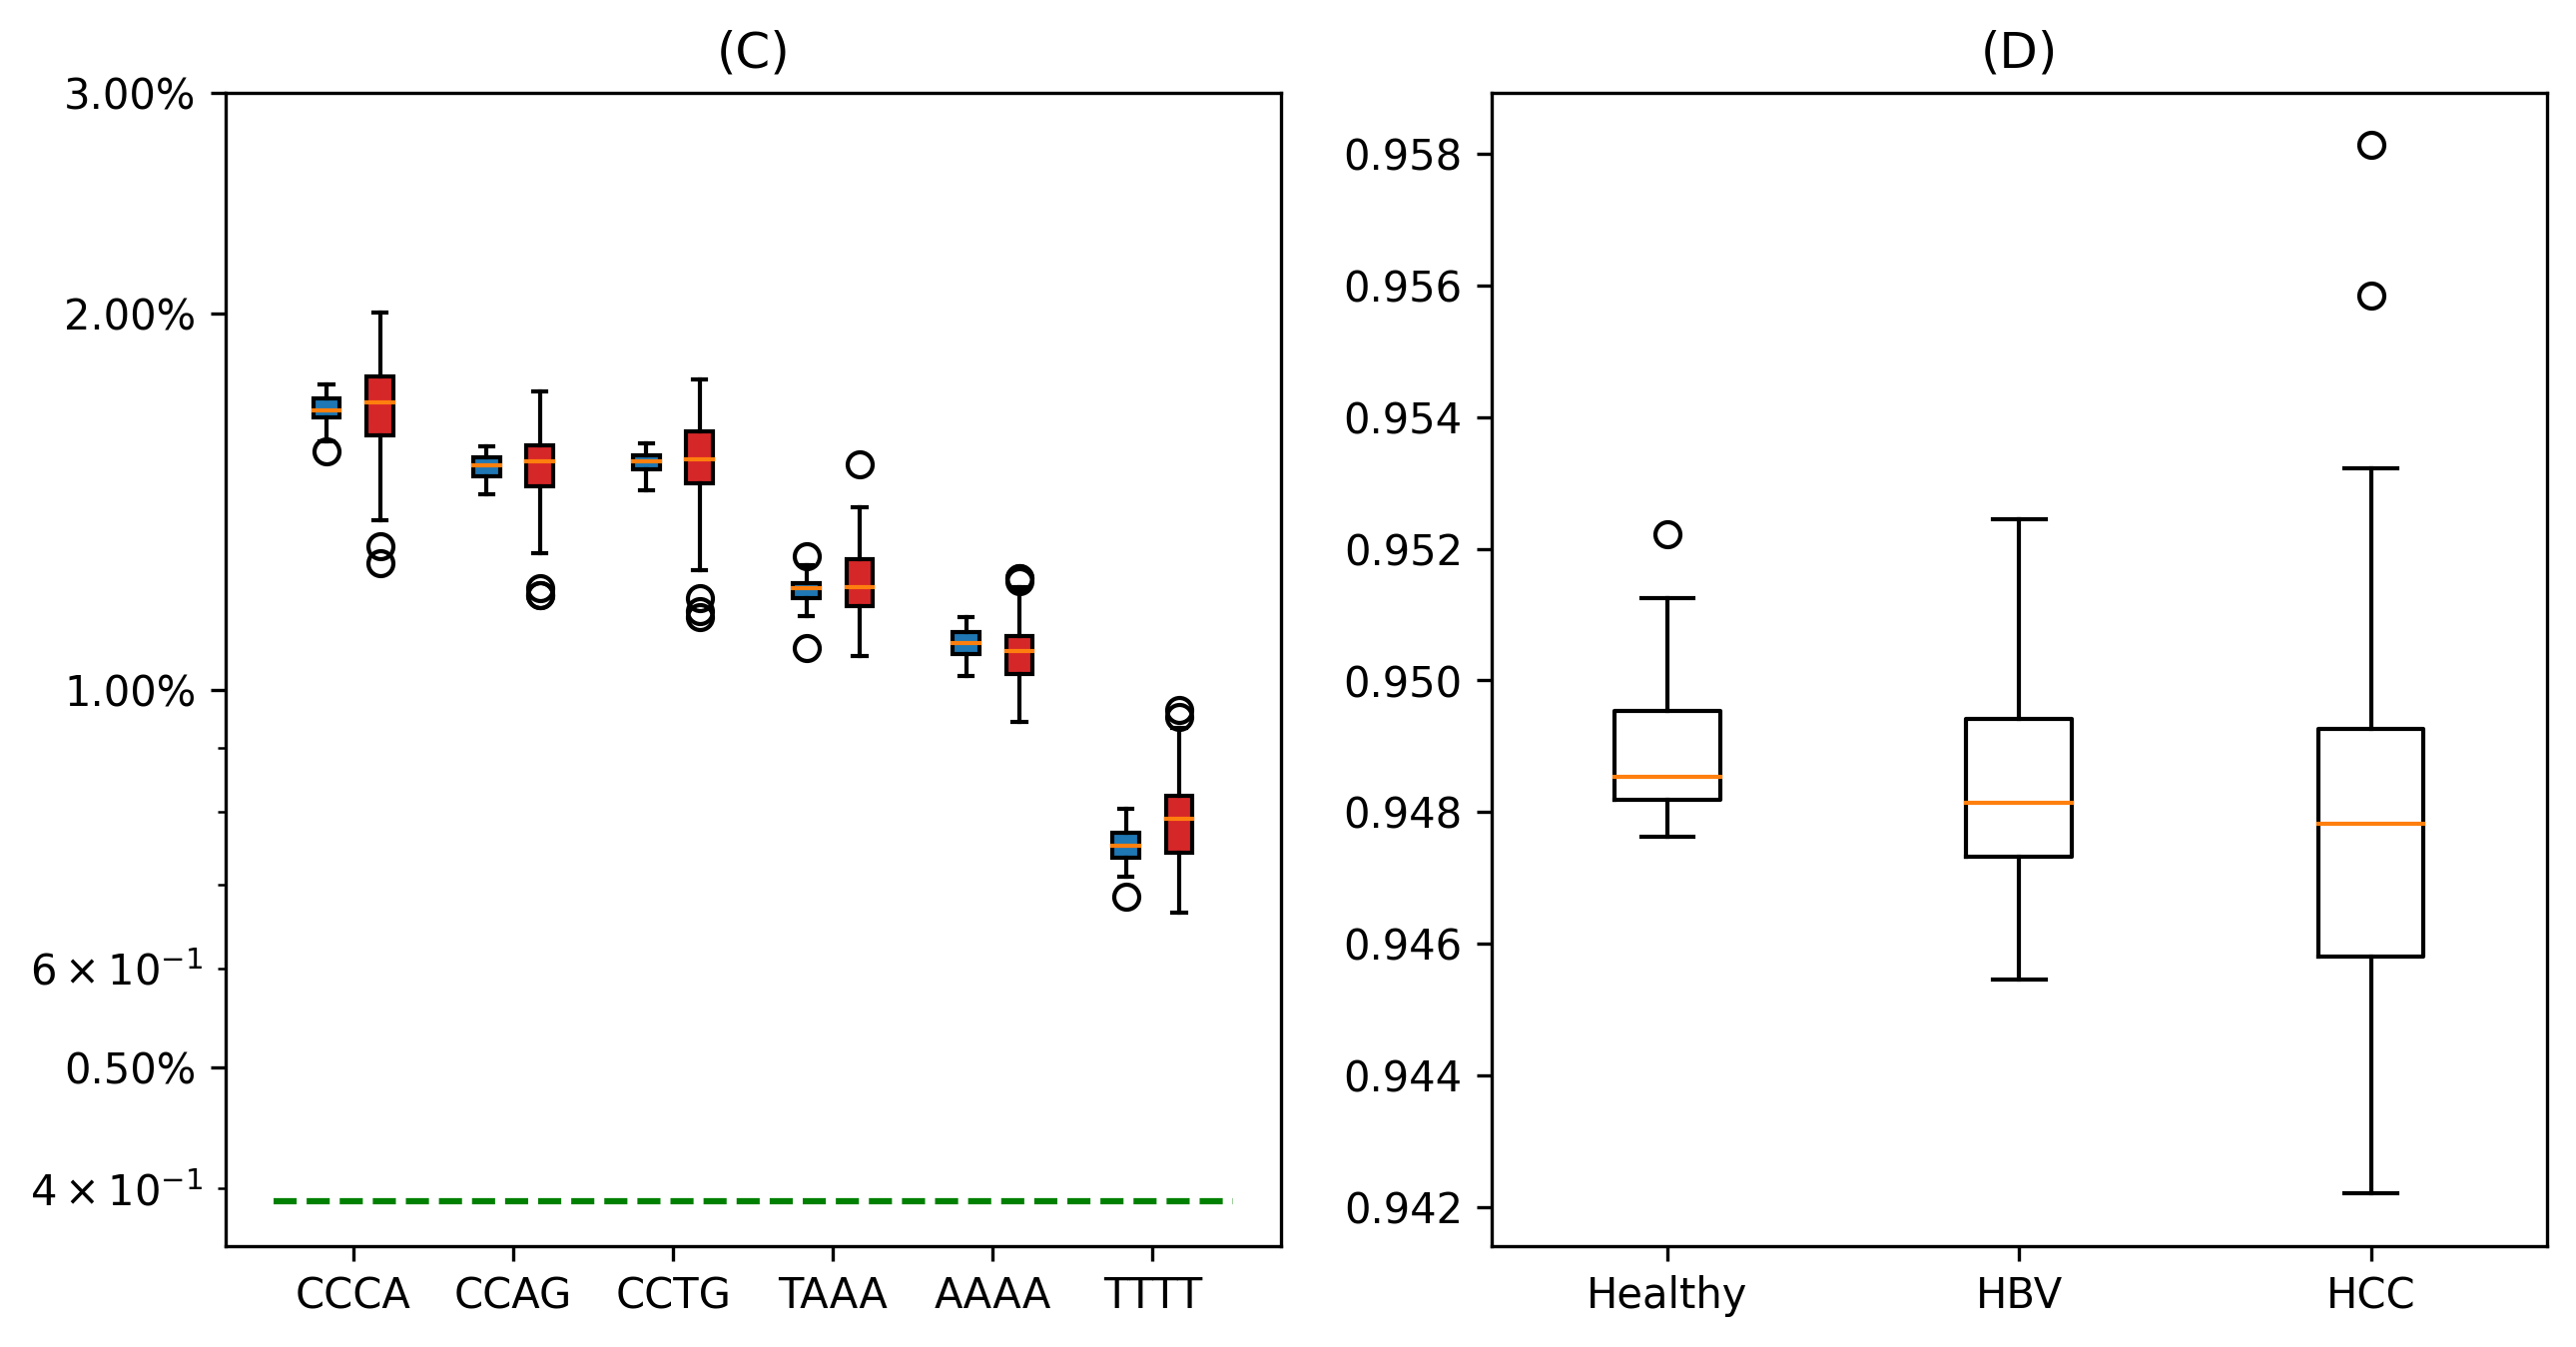

In [120]:
# plotting
fig, axes = plt.subplots(1, 2)
fig.set_dpi(300)
fig.set_size_inches(10, 5)

# Box plot for HCC motifs
motif_box_plot = axes[0].boxplot(
        motif_freq_list,
        labels=labels,
        positions=positions,
        patch_artist=True,
)
for patch, color in zip(motif_box_plot['boxes'], colors):
        patch.set_facecolor(color)
axes[0].plot([0, 18], [100/256, 100/256], 'g--')
axes[0].set_xticks(ticks, tick_labels)
# FIXME: add legend

# Box plot for MDS
mds_box_plot = axes[1].boxplot(
        mds_series,
)
axes[1].set_xticks([1, 2, 3], ['Healthy', 'HBV', 'HCC'])
axes[0].set_title('(C)')
axes[1].set_title('(D)')
axes[0].set_yscale('log')
y_formatter = mpl.ticker.PercentFormatter()
axes[0].yaxis.set_major_formatter(y_formatter)
axes[0].set_yticks([0.5, 1, 2, 3])


### For Snyder et al (2016)

Text(0, 0.5, 'Motif diversity score')

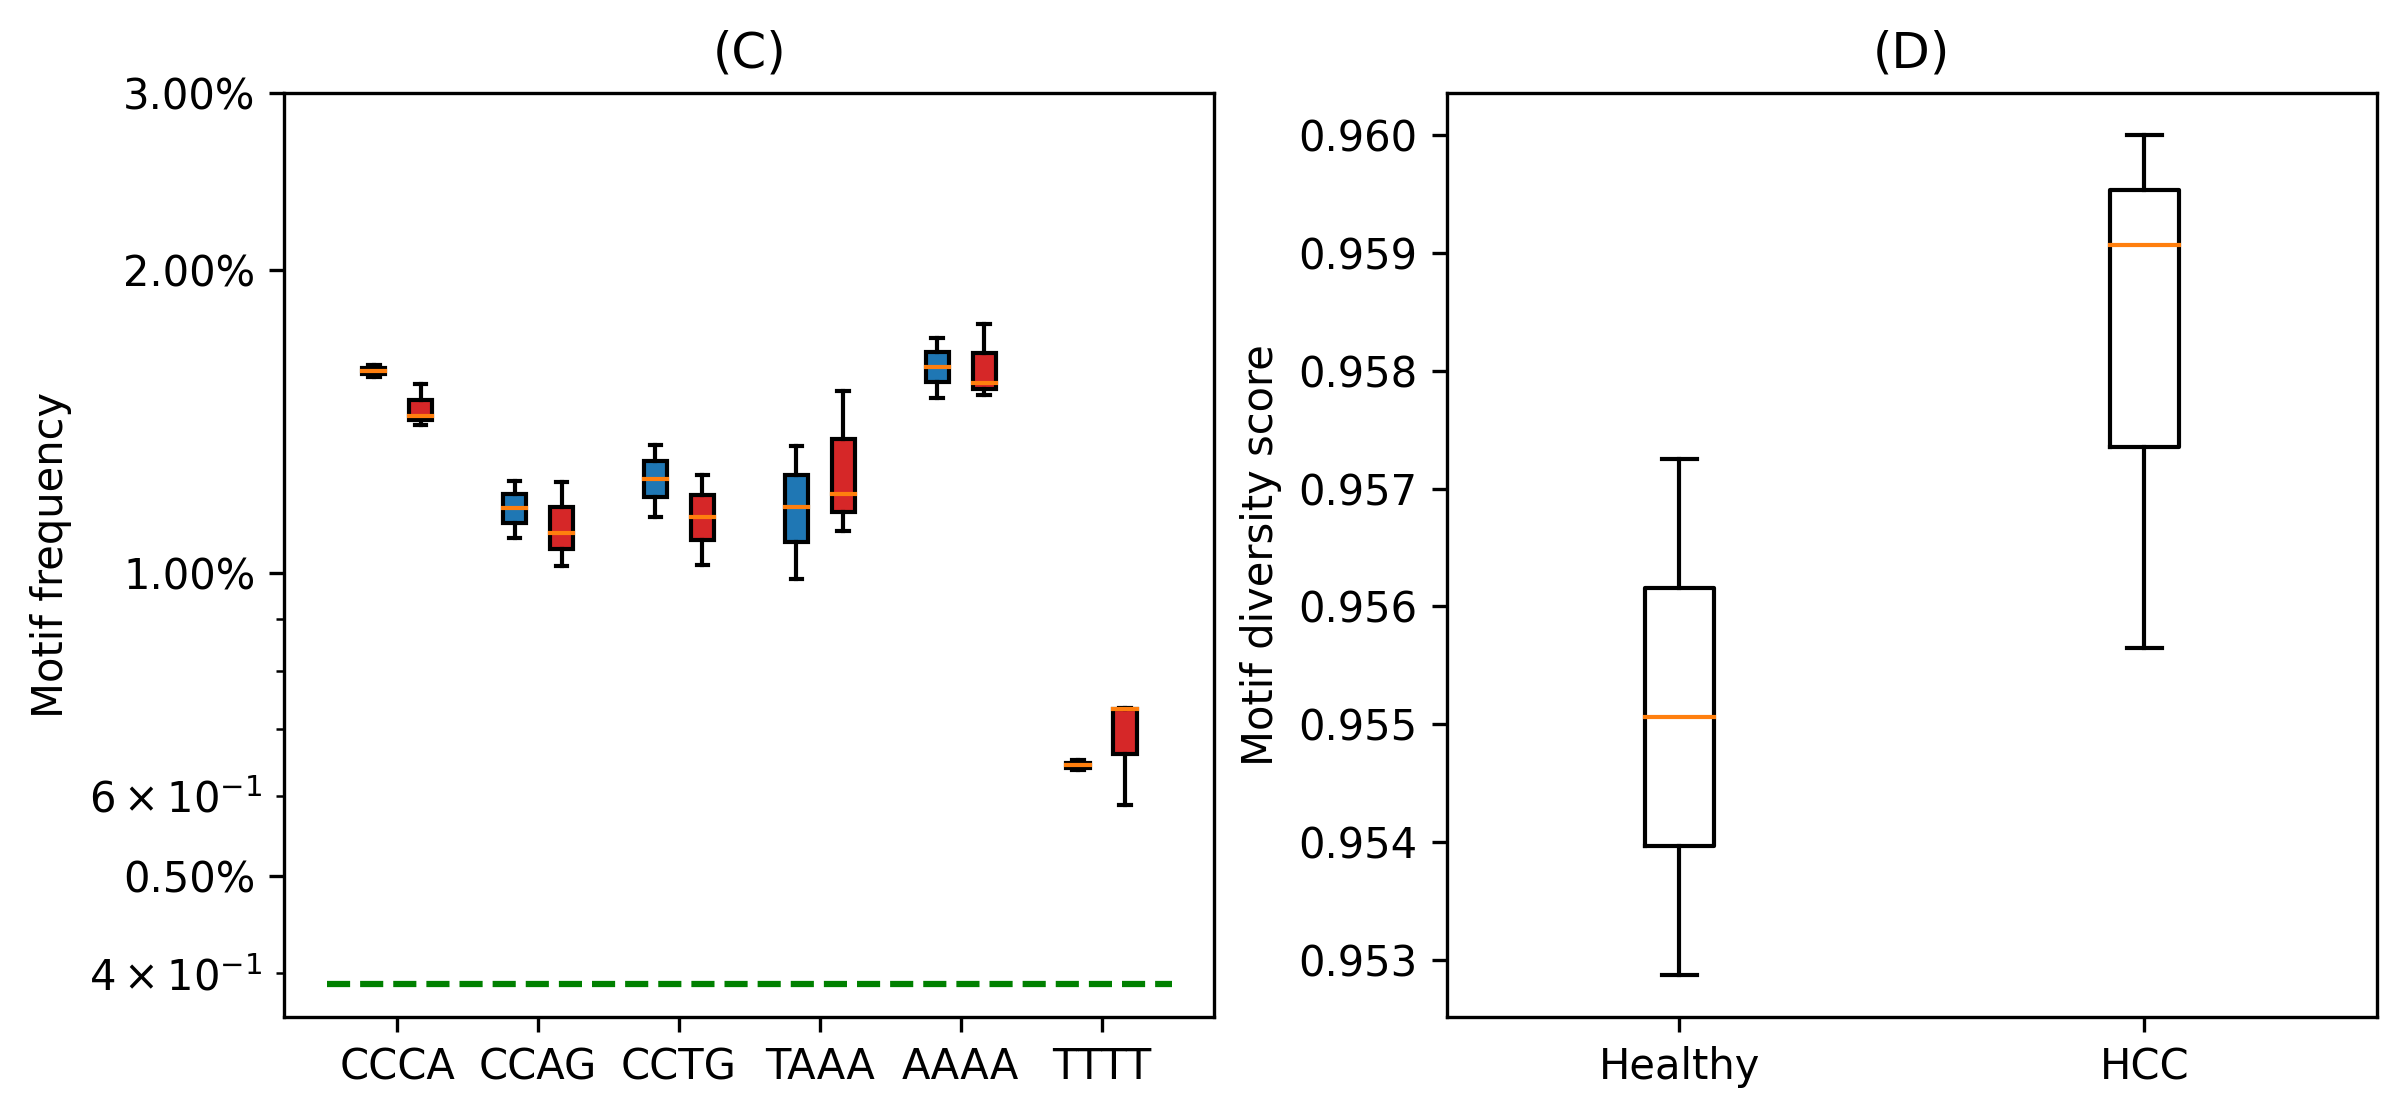

In [121]:
# read data from csv. The csv is our end-motif calculations on a dataset
# from Snyder et al (2016), which is different from the data used in 
# Jiang et al (2020).
end_motifs_csv = pd.read_csv('../data/snyder_end_motifs_Jul26.csv')
end_motifs_csv
# get mds for Healthy, HBV, and HCC
# NOTE: this dataset was retrived from FinaleDB, which uses the 'Liver
# cancer' label for some samples. Jiang et al (2015) makes no mention of
# non-HCC liver cancers in their patients, so it is assumed that all
# samples labled 'Liver cancer' are also HCC.
healthy_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Healthy', 'mds']
hbv_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Hepatitis B', 'mds']
hcc_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', 'mds']
mds_series = [healthy_mds, hcc_mds]
healthy_mds
# Get motif freqs of non-HCC and HCC patients for six motifs of interest
# for HCC
motifs = ['CCCA', 'CCAG', 'CCTG', 'TAAA', 'AAAA', 'TTTT']

# motif-freqs are stored in DataFrames in a list. For each motif there
# is a DataFrame for Non-HCC and a DataFrame for HCC

motif_freq_list = []
for motif in motifs:
    non_hcc = end_motifs_csv.loc[(end_motifs_csv['disease']=='Healthy')|(end_motifs_csv['disease']=='Hepatitis B'), motif]
    hcc = end_motifs_csv.loc[(end_motifs_csv['disease']=='Liver cancer')&(end_motifs_csv['id']!='86258'), motif]
    motif_freq_list.append(non_hcc*100)
    motif_freq_list.append(hcc*100)
motif_freq_list[1]

# box plot positions, colors, x tick labels
colors = []
positions = []
labels = []
ticks = []
tick_labels = []
for i in range(len(motifs)):
    positions.append(3*i+1)
    positions.append(3*i+2)
    ticks.append(3*i+1.5)
    tick_labels.append(motifs[i])
    colors.append('C0')
    colors.append('C3')
    labels.append('Non-HCC')
    labels.append('HCC')
# plotting
fig, axes = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.25)
fig.set_dpi(300)
fig.set_size_inches(9, 4)

# Box plot for HCC motifs
motif_box_plot = axes[0].boxplot(
        motif_freq_list,
        labels=labels,
        positions=positions,
        patch_artist=True,
)
for patch, color in zip(motif_box_plot['boxes'], colors):
        patch.set_facecolor(color)
axes[0].plot([0, 18], [100/256, 100/256], 'g--')
axes[0].set_xticks(ticks, tick_labels)
# FIXME: add legend

# Box plot for MDS
mds_box_plot = axes[1].boxplot(
        mds_series,
)
axes[1].set_xticks([1,2], ['Healthy','HCC'])
axes[0].set_title('(C)')
axes[1].set_title('(D)')
axes[0].set_yscale('log')
y_formatter = mpl.ticker.PercentFormatter()
axes[0].yaxis.set_major_formatter(y_formatter)
axes[0].set_yticks([0.5, 1, 2, 3])

axes[0].set_ylabel('Motif frequency')

axes[1].set_ylabel('Motif diversity score')

In [151]:
#End motifs bar graph
end_motifs = pd.read_csv('../data/BH01_kmers.tsv', sep='\t', header=None, names=['kmer', 'freq'])
end_motifs

,kmer,freq
0,AAAA,0.010185
1,AAAC,0.003726
2,AAAG,0.006096
3,AAAT,0.006635
4,AACA,0.004362
...,...,...
251,TTGT,0.001996
252,TTTA,0.004324
253,TTTC,0.002857
254,TTTG,0.002518


In [152]:
color_dict = {
    'A': 'blue',
    'C': 'red',
    'G': 'green',
    'T': 'yellow',
}

end_motifs['colors'] = end_motifs['kmer'].map(lambda x: color_dict[x[0]])
end_motifs

,kmer,freq,colors
0,AAAA,0.010185,blue
1,AAAC,0.003726,blue
2,AAAG,0.006096,blue
3,AAAT,0.006635,blue
4,AACA,0.004362,blue
...,...,...,...
251,TTGT,0.001996,yellow
252,TTTA,0.004324,yellow
253,TTTC,0.002857,yellow
254,TTTG,0.002518,yellow


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

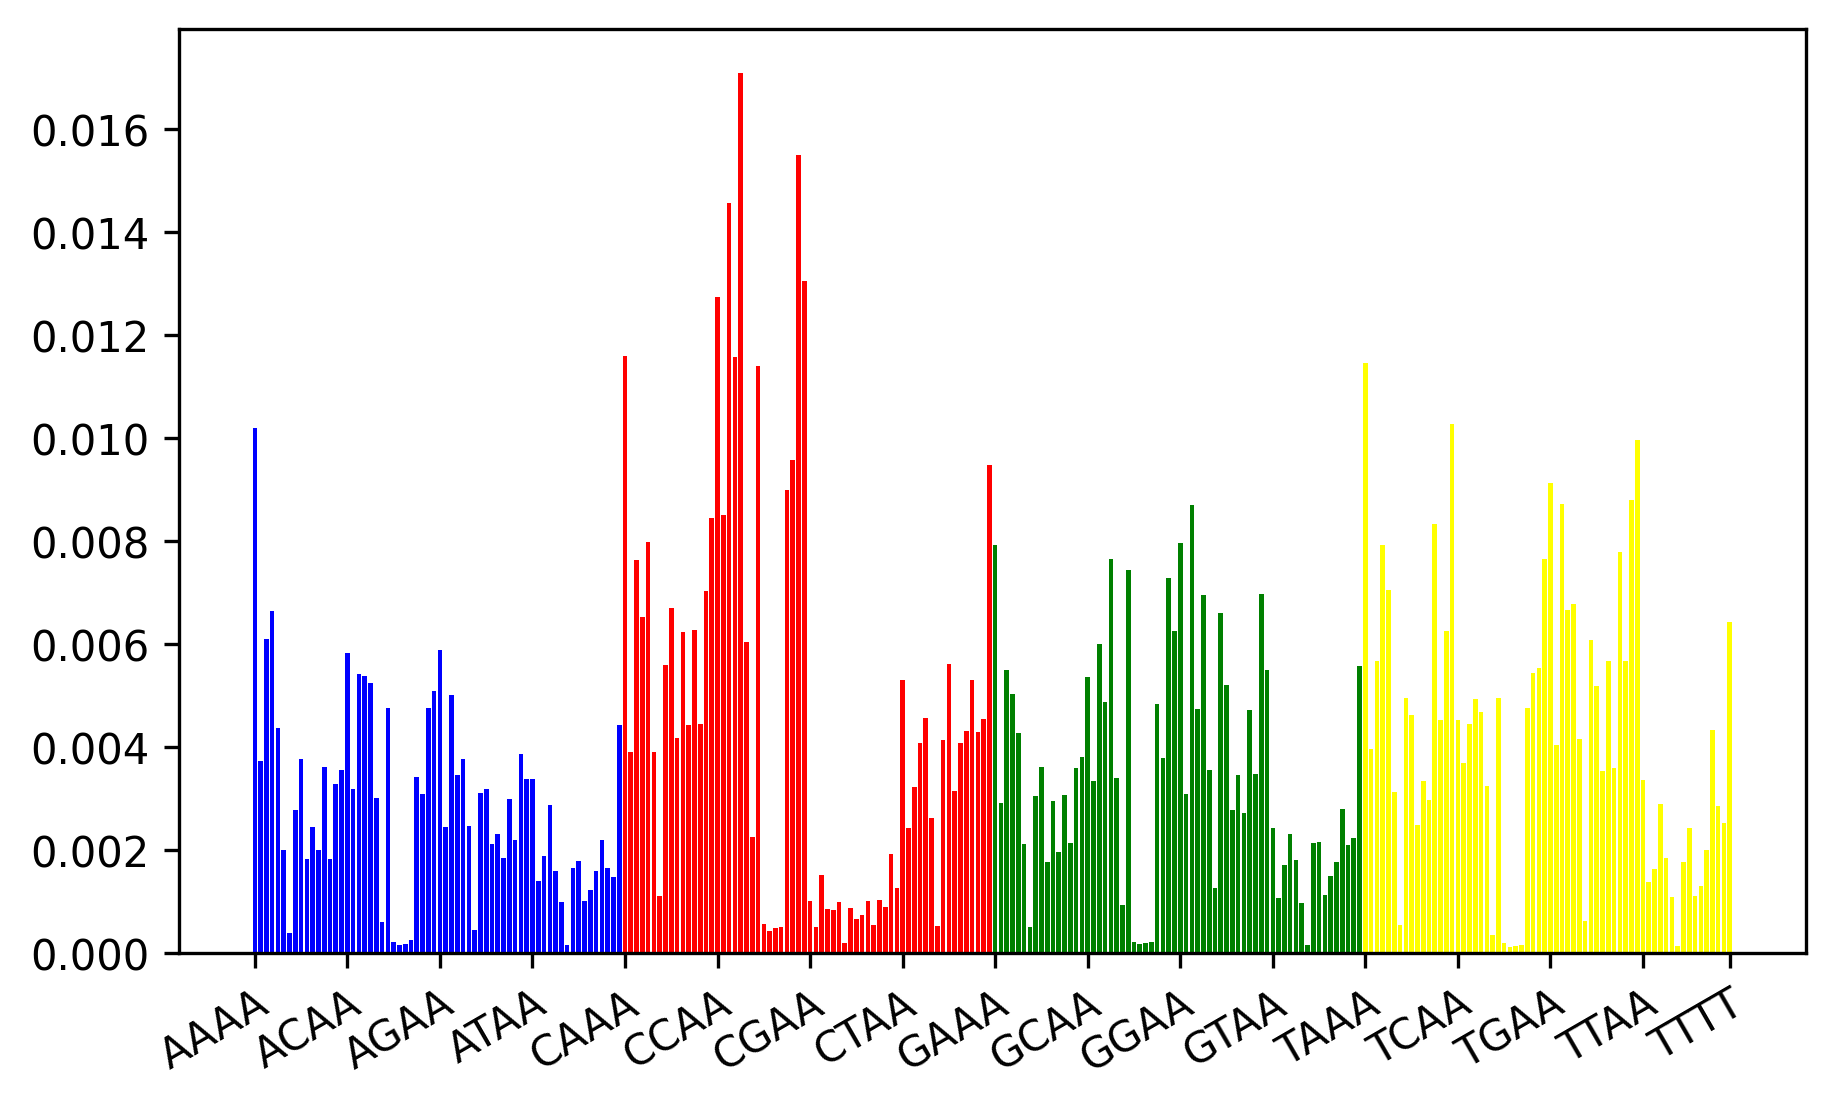

In [161]:
fig, ax = plt.subplots(1)
fig.set_dpi(300)
fig.set_size_inches(7, 4)

ax.bar(end_motifs['kmer'], end_motifs['freq'], color=end_motifs['colors'])
ax.set_xticks(['AAAA', 'ACAA', 'AGAA', 'ATAA', 'CAAA', 'CCAA', 'CGAA', 'CTAA', 'GAAA', 'GCAA', 'GGAA', 'GTAA', 'TAAA', 'TCAA', 'TGAA', 'TTAA', 'TTTT'])
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")


In [176]:
end_motifs_csv = pd.read_csv('../data/jiang_end_motifs_Jul26.csv')
kmers = end_motifs['kmer']
jiang_end_motifs = end_motifs_csv.loc[150, kmers]
jiang_end_motifs

AAAA    0.010891
AAAC    0.003559
AAAG    0.006051
AAAT    0.006181
AACA    0.003905
          ...   
TTGT    0.002128
TTTA    0.004222
TTTC    0.003159
TTTG     0.00299
TTTT     0.00729
Name: 150, Length: 256, dtype: object

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

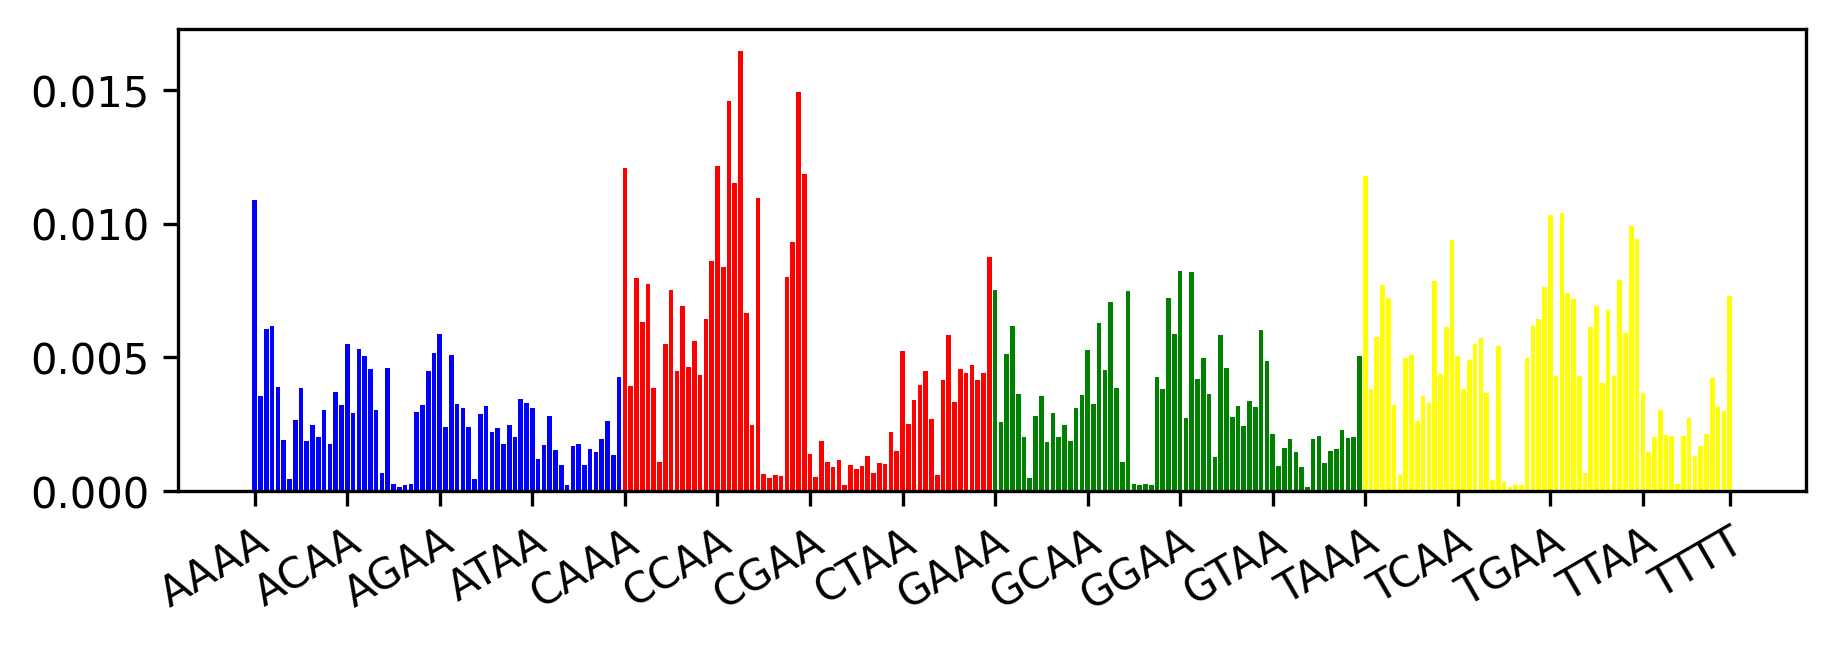

In [177]:
fig, ax = plt.subplots(1)
fig.set_dpi(300)
fig.set_size_inches(7, 2)

ax.bar(end_motifs['kmer'], jiang_end_motifs, color=end_motifs['colors'])
ax.set_xticks(['AAAA', 'ACAA', 'AGAA', 'ATAA', 'CAAA', 'CCAA', 'CGAA', 'CTAA', 'GAAA', 'GCAA', 'GGAA', 'GTAA', 'TAAA', 'TCAA', 'TGAA', 'TTAA', 'TTTT'])
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")

## Frag Length and Coverage

In [114]:
bins, counts = frag_length_bins('../../../Documents/2023_summer/finaletools-demo/Jan28.hg19.mdups.bam', '1', 2000000, 3000000, histogram=True)
bins, counts

Fragment Lengths for 1:68-285
                        ▇                              mean      :168.82
                        █▂                             median    :169.00
                        ██                             stdev     : 25.90
                        ██▆                            min       : 68.00
                        ███                            max       :285.00
                       ▇███▃                          
                       █████                          
                       █████                          
                      ▁█████                          
                      ██████▁                         
                      ███████                         
                     ▂███████▃                        
                    ▁█████████▁                       
                    ███████████                       
                  ▁▅███████████▄                      
                  ██████████████▄                     


(array([ 68,  72,  76,  80,  84,  88,  92,  96, 100, 104, 108, 112, 116,
        120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168,
        172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220,
        224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272,
        276, 280, 284, 285]),
 [4,
  10,
  11,
  19,
  17,
  27,
  19,
  26,
  27,
  33,
  33,
  46,
  61,
  66,
  51,
  71,
  119,
  144,
  205,
  233,
  310,
  366,
  510,
  694,
  948,
  866,
  792,
  670,
  459,
  370,
  310,
  227,
  177,
  126,
  106,
  91,
  42,
  49,
  34,
  31,
  20,
  14,
  15,
  28,
  13,
  11,
  8,
  16,
  13,
  13,
  12,
  14,
  6,
  14,
  4])

In [89]:
with open('../data/example_intervals.bed', 'w') as bed:
    for i in range(1000000, 3000000, 100000):
        bed.write(f'1\t{i}\t{i+100000}\n')

coverages = coverage('../../../Documents/2023_summer/finaletools-demo/Jan28.hg19.mdups.bam', '../data/example_intervals.bed', output_file=None, workers=6)

In [91]:
example_coverage = [cov for cov in coverages]

In [94]:
example_coverage = np.array(example_coverage, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('name', '<U4'), ('coverage', '<f8')])
example_coverage

array([('1', 1000000, 1100000, '.',  735.),
       ('1', 1100000, 1200000, '.',  816.),
       ('1', 1200000, 1300000, '.',  709.),
       ('1', 1300000, 1400000, '.',  677.),
       ('1', 1400000, 1500000, '.',  675.),
       ('1', 1500000, 1600000, '.',  574.),
       ('1', 1600000, 1700000, '.',  473.),
       ('1', 1700000, 1800000, '.',  711.),
       ('1', 1800000, 1900000, '.',  792.),
       ('1', 1900000, 2000000, '.',  841.),
       ('1', 2000000, 2100000, '.',  821.),
       ('1', 2100000, 2200000, '.',  709.),
       ('1', 2200000, 2300000, '.',  822.),
       ('1', 2300000, 2400000, '.',  878.),
       ('1', 2400000, 2500000, '.',  850.),
       ('1', 2500000, 2600000, '.', 1078.),
       ('1', 2600000, 2700000, '.',  627.),
       ('1', 2700000, 2800000, '.',  945.),
       ('1', 2800000, 2900000, '.',  960.),
       ('1', 2900000, 3000000, '.',  907.)],
      dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('name', '<U4'), ('coverage', '<f8')])

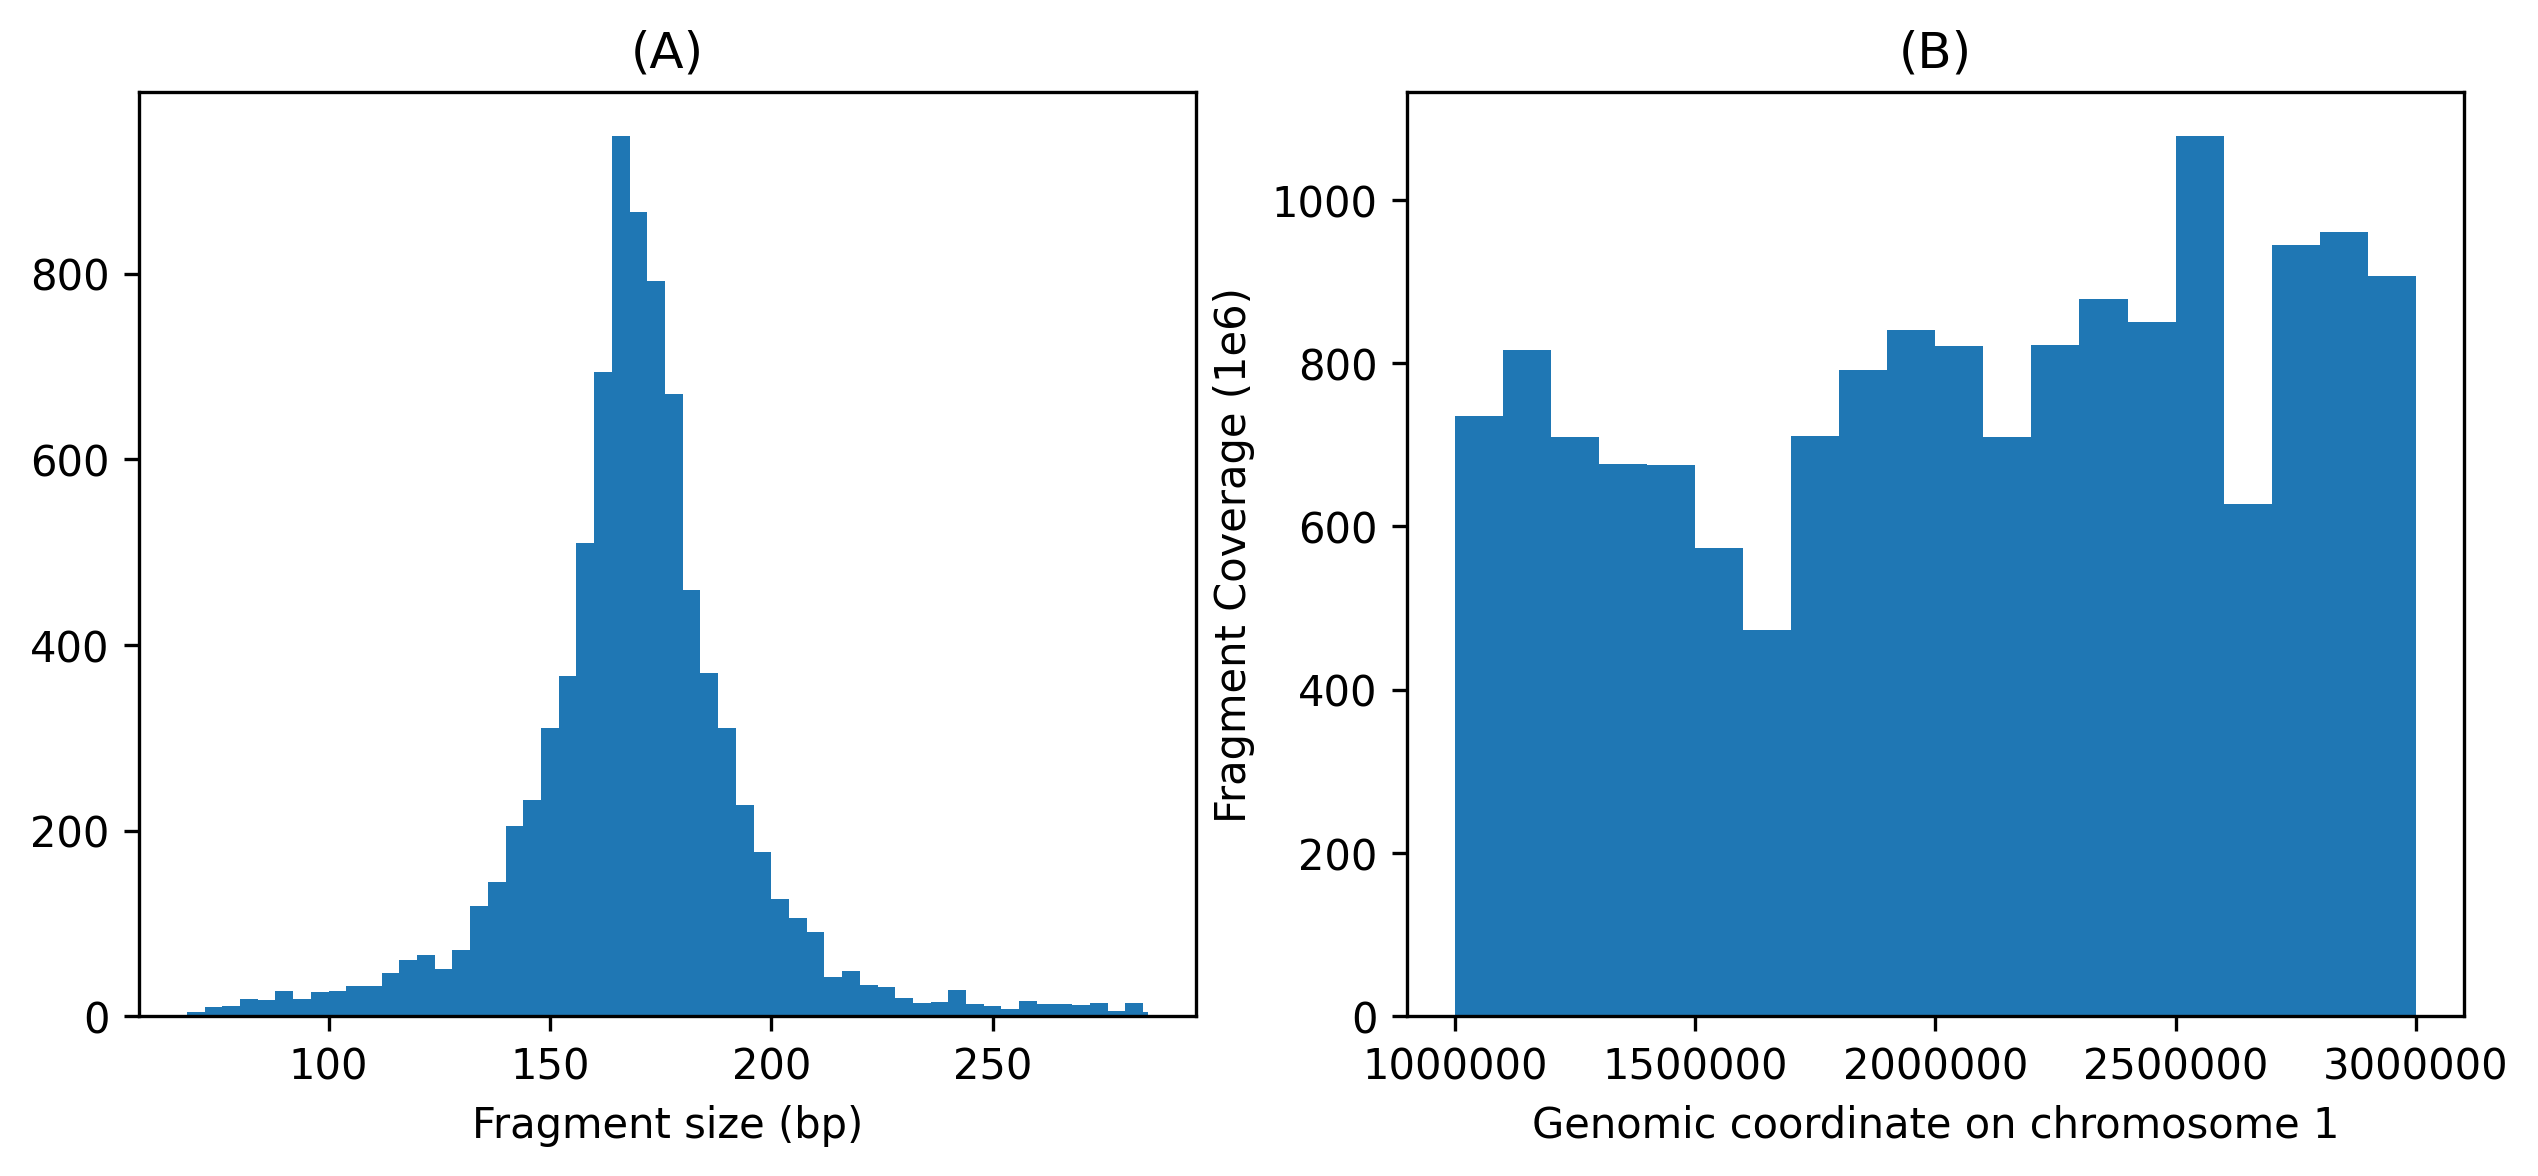

In [117]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(300)
fig.set_size_inches(10, 4)

axes[0].hist(bins[:-1], bins, weights=counts)
axes[0].set_xlabel('Fragment size (bp)')
axes[0].set_title('(A)')

axes[1].bar(example_coverage['start'], example_coverage['coverage'], width=100000, align='edge')

x_formatter = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
x_formatter.set_scientific(False)
axes[1].xaxis.set_major_formatter(x_formatter)
axes[1].set_xlabel('Genomic coordinate on chromosome 1')
axes[1].set_ylabel('Fragment Coverage (1e6)')
axes[1].set_title('(B)')

plt.show()